In [35]:
import json
import numpy as np
import pandas as pd

In [2]:
from run_config_json import create_run_config_json

In [108]:
num_runs = 5
num_consensus = 10
starting_seed = 0
seed_multiplier = 100
node_processing_rate = 3
switch_processing_rate = 9
base_time_limit = 10000
network_type = "Torus"
network_parameters = [4]

In [94]:
VALIDATOR_RESULTS_FILEPATH = "../json/validator_results.json"
NEW_ROUND_KEY = "t_newRound"
PREPREPARED_KEY = "t_prePrepared"
PREPARED_KEY = "t_prepared"
ROUND_CHANGE_KEY = "t_roundChange"
TOTAL_KEY = "t_total"

time_keys = [NEW_ROUND_KEY, PREPREPARED_KEY, PREPARED_KEY, ROUND_CHANGE_KEY, TOTAL_KEY]

In [109]:
results_dic = {}
for num_nodes in [4, 8, 16, 32, 64]:
    json_obj = create_run_config_json(num_runs, num_consensus, starting_seed, seed_multiplier,
                                      num_nodes, node_processing_rate, switch_processing_rate, base_time_limit, 
                                      network_type, network_parameters)
    config_filename = "config.json"
    with open(config_filename, "w") as config_file:
        config_file.write(json_obj)
    argument = "py/" + config_filename
    ! (cd "../" && gradlew run --args={argument})
    with open(VALIDATOR_RESULTS_FILEPATH, "r") as validator_results_json:
        validator_results = json.load(validator_results_json)
    results_dic[num_nodes] = validator_results


> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE

> Task :run
Total node count: 20
Total consensus count: 10
Average time at state NEW_ROUND per node per instance: 1.1409653611067374
Average time at state PRE_PREPARED per node per instance: 1.4757643559859628
Average time at state PREPARED per node per instance: 1.5630663873804573
Average time at state ROUND_CHANGE per node per instance: 0.0
Average time per consensus instance per node: 4.179796104473157
Total time: 41.79796104473157

Average queue stats
Average number of messages in queue: 1.6148327415192982
Average effective arrival rate: 2.1580000015663265
Average waiting time per message: 0.7483006211062164
Product of waiting time and arrival rate: 1.6148327415192982
Total time: 41.79796104473157

BUILD SUCCESSFUL in 2s
2 actionable tasks: 1 executed, 1 up-to-date
> Task :compileJava UP-TO-DATE
> Task :processResources NO-SOURCE
> Task :classes UP-TO-DATE

> Task :run
Total node count: 40

In [110]:
df = pd.DataFrame(results_dic).transpose()

<AxesSubplot:>

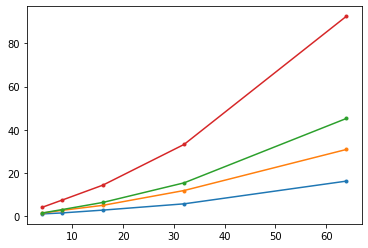

In [111]:
df[NEW_ROUND_KEY].plot(style=".-")
df[PREPREPARED_KEY].plot(style=".-")
df[PREPARED_KEY].plot(style=".-")
df[TOTAL_KEY].plot(style=".-")

{4: {'t_newRound': 1.1389651177741338,
  't_prePrepared': 1.5385546988468215,
  't_prepared': 1.738017297900246,
  't_roundChange': 0.0,
  't_total': 4.415537114521202},
 8: {'t_newRound': 1.9415501723545305,
  't_prePrepared': 3.2249524534764773,
  't_prepared': 3.6464096183251433,
  't_roundChange': 0.0,
  't_total': 8.812912244156152},
 12: {'t_newRound': 1.9415501723545305,
  't_prePrepared': 3.2249524534764773,
  't_prepared': 3.6464096183251433,
  't_roundChange': 0.0,
  't_total': 8.812912244156152},
 16: {'t_newRound': 3.2482524994735797,
  't_prePrepared': 6.213841357061402,
  't_prepared': 7.40369636232519,
  't_roundChange': 0.0,
  't_total': 16.865790218860177},
 32: {'t_newRound': 5.417559987929825,
  't_prePrepared': 12.790494090238521,
  't_prepared': 14.967386681074533,
  't_roundChange': 0.0,
  't_total': 33.175440759242875},
 48: {'t_newRound': 5.417559987929825,
  't_prePrepared': 12.790494090238521,
  't_prepared': 14.967386681074533,
  't_roundChange': 0.0,
  't_to